# Reprocess Building  spectra for AuxTel

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 2nd  2021
- creation update : April 2nd 2021
- update : June 7th 2021 : for ccin2p3
- version v0
- kernel anaconda3_auxtel

# Imports

In [428]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [429]:
%matplotlib inline

In [430]:
from iminuit import Minuit
import iminuit

In [431]:
iminuit.__version__

'2.2.0'

In [432]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [433]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9][0-9][0-9][0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Path

In [434]:
path_auxtel="/sps/lsst/groups/auxtel"
path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
path_spectractor_config=os.path.join(path_spectractor,"config")
path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")

# Logbook for file selection

In [435]:
filename_logbook='logbooks/auxtelholologbook_2021_07_06_v2.0.csv'

In [436]:
df=pd.read_csv(filename_logbook)

In [437]:
pd.set_option('display.max_rows', None)

In [438]:
df

,Unnamed: 0,index,date,path,file,num,object,filter,disperser,airmass,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,0,2021-07-07T01:16:33.033,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000098.fits,98,HD120144,RG610,holo4_003,1.112792,...,7.0,16.0,11.6,256.0,2130.0,NaN,NaN,,1.0,1.0
1,1,1,2021-07-07T01:17:01.054,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000099.fits,99,HD120144,RG610,holo4_003,1.113402,...,7.0,16.0,11.6,256.0,2130.0,NaN,NaN,,1.0,1.0
2,2,2,2021-07-07T01:17:25.525,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000100.fits,100,HD120144,RG610,holo4_003,1.113971,...,7.0,16.0,11.6,256.0,2300.0,NaN,NaN,,1.0,1.0
3,3,3,2021-07-07T01:17:50.010,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000101.fits,101,HD120144,RG610,holo4_003,1.114548,...,7.0,15.0,13.1,256.0,2300.0,NaN,NaN,,1.0,1.0
4,4,4,2021-07-07T01:18:14.601,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000102.fits,102,HD120144,RG610,holo4_003,1.115124,...,7.0,15.0,13.1,256.0,2300.0,NaN,NaN,,1.0,1.0
5,5,5,2021-07-07T01:18:38.991,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000103.fits,103,HD120144,RG610,holo4_003,1.115701,...,7.1,15.0,10.9,256.0,2300.0,NaN,NaN,,1.0,1.0
6,6,6,2021-07-07T01:19:03.593,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000104.fits,104,HD120144,RG610,holo4_003,1.116286,...,7.1,15.0,10.9,256.0,2300.0,NaN,NaN,,1.0,1.0
7,7,7,2021-07-07T01:19:27.983,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000105.fits,105,HD120144,RG610,holo4_003,1.116869,...,7.1,15.0,10.9,256.0,2300.0,NaN,NaN,,1.0,1.0
8,8,8,2021-07-07T01:19:52.570,/sps/lsst/groups/auxtel/data/2021/holo/localre...,Cor_holo4_003_RG610_HD120144_20210706_000106.fits,106,HD120144,RG610,holo4_003,1.117460,...,7.2,14.0,9.9,256.0,2300.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [439]:
index_sel=7 # SELECTION

In [440]:
myhome=os.getenv("HOME")

In [441]:
dir_images=path_images

In [442]:
filename_image=df["file"][index_sel]

In [443]:
file_target(filename_image)

['HD120144']

In [444]:
xpos=df["Obj-posXpix"][index_sel]
ypos=df["Obj-posYpix"][index_sel]

In [445]:
#! mkdir figures_reprocess

In [446]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_reprocess/"
output_figures="figures_reprocess"
guess = [xpos,ypos]
disperser_label = df["disperser"][index_sel]
config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
target = file_target(filename_image)[0]

In [447]:
os.path.isdir(output_directory)

True

In [448]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)

In [449]:
#spectractor_dir="/Users/dagoret/MacOSX/GitHub/LSST/SpectractorNew/spectractor"

# Configuration of the running mode

In [450]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [451]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Load an image

In [452]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-07-07 20:49:33  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000105.fits...
2021-07-07 20:49:33  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000105.fits...
2021-07-07 20:49:33  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-07-07 20:49:33  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-07-07 20:49:34  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 20:49:34  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 20:49:34  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-07-07 20:49:34  Hologram

## Show relevant parameters

In [453]:
parameters.OBS_NAME

'AUXTEL'

In [454]:
parameters.DISPERSER_DIR

'/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [455]:
parameters.DISTANCE2CCD

182.0

In [456]:
parameters.LAMBDA_MIN 

563

In [457]:
parameters.LAMBDA_MAX 

1095

In [458]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [459]:
image.filter_label

'RG610'

In [460]:
image.header["FILTER"]

'RG610'

# Plot image and find the target position

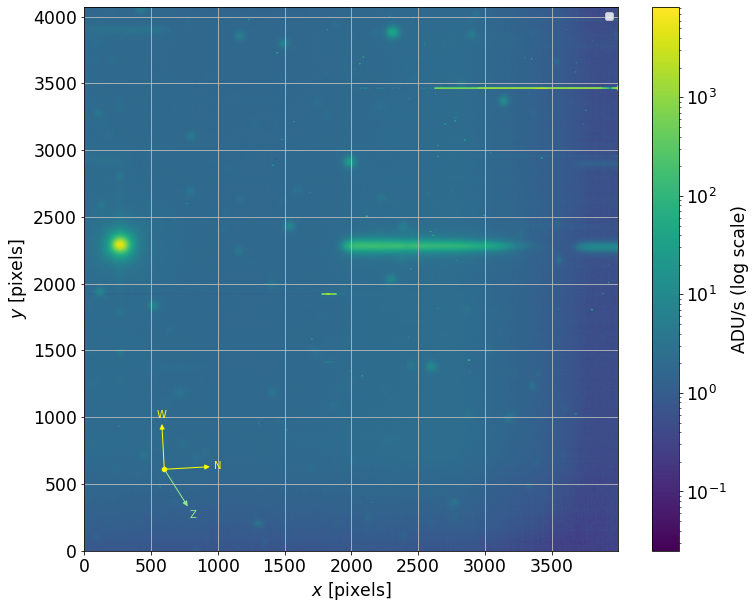

In [461]:
image.plot_image(figsize=(12, 10),scale="log")

# Find target

2021-07-07 20:49:45  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    29.820568656741294 0.14321261430595766 -0.06282109452855532
2021-07-07 20:49:45  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    29.820568656741294 0.14321261430595766 -0.06282109452855532
2021-07-07 20:49:45  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=1.25e-05.
2021-07-07 20:49:45  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent termina

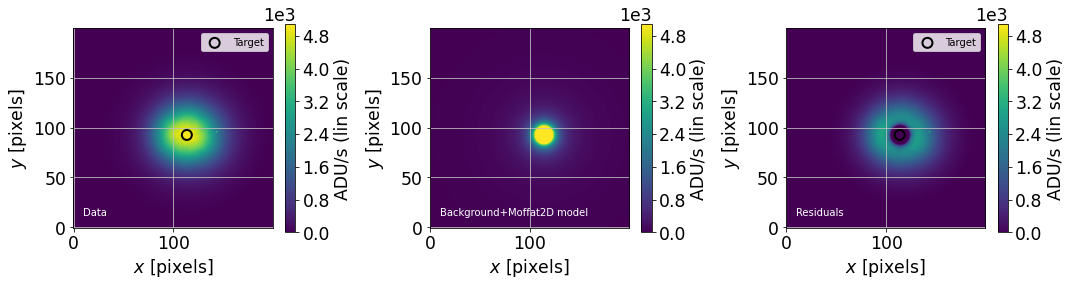

2021-07-07 20:49:46  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.
2021-07-07 20:49:46  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.


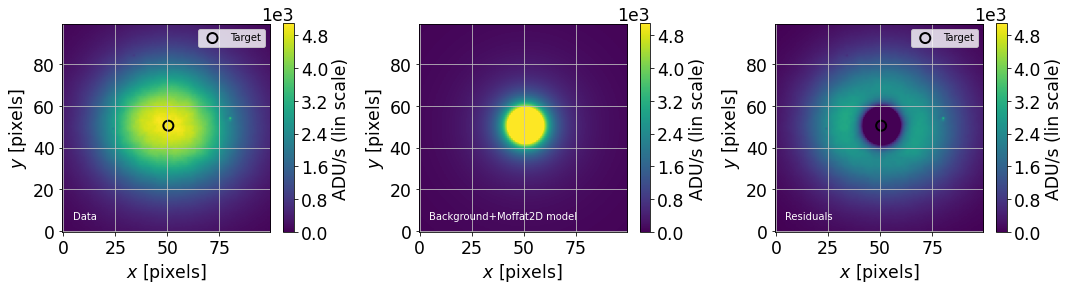

2021-07-07 20:49:47  Image      find_target          INFO   
	X,Y target position in pixels: 269.502,2292.482
2021-07-07 20:49:47  Image      find_target          INFO   
	X,Y target position in pixels: 269.502,2292.482


In [462]:
parameters.VERBOSE = True
parameters.DEBUG = True
x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)

In [463]:
print(x1,y1)

269.5018090825156 2292.4819894153634


# Go for spectrum reconstruction

2021-07-07 20:49:47  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-07-07 20:49:47  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-07-07 20:49:47  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000105.fits...
2021-07-07 20:49:47  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000105.fits...
2021-07-07 20:49:47  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-07-07 20:49:47  Image      load_AUXTEL_image    INFO   
	Image loaded
2021-07-07 20:49:48  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 20:49:48  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 20:49:48  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-07-07 20:49:48  Hologram

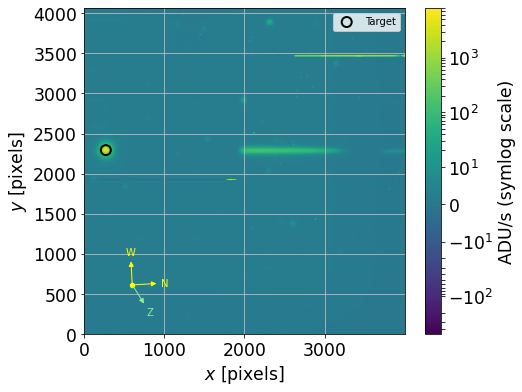

2021-07-07 20:49:57  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 269.50180908 2292.48198942]...
2021-07-07 20:49:57  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 269.50180908 2292.48198942]...
2021-07-07 20:49:57  spectractor.extractor.images find_target          INFO   
	No WCS /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000105_wcs/Cor_holo4_003_RG610_HD120144_20210706_000105.wcs available, use 2D fit to find target pixel position.
2021-07-07 20:49:57  spectractor.extractor.images find_target          INFO   
	No WCS /sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-07-06/Cor_holo4_003_RG610_HD120144_20210706_000105_wcs/Cor_holo4_003_RG610_HD120144_20210706_000105.wcs available, use 2D fit to find target pixel position.
2021-07-07 20:49:58  spectractor.tools fit_poly2d_outlier_removal INFO   


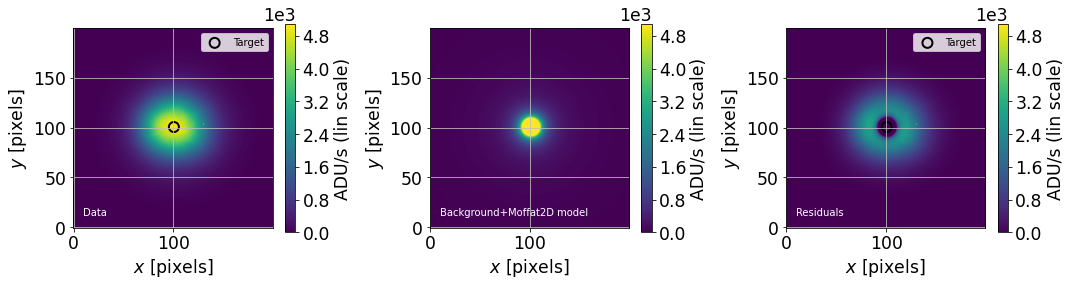

2021-07-07 20:49:59  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.
2021-07-07 20:49:59  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=5e-05.


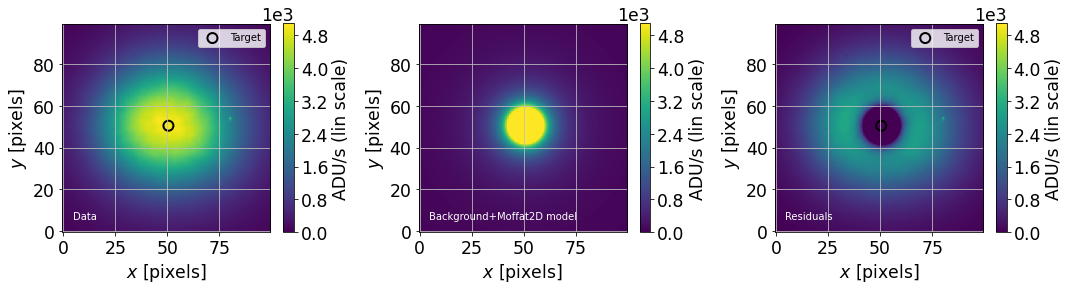

2021-07-07 20:50:00  Image      find_target          INFO   
	X,Y target position in pixels: 269.537,2292.466
2021-07-07 20:50:00  Image      find_target          INFO   
	X,Y target position in pixels: 269.537,2292.466


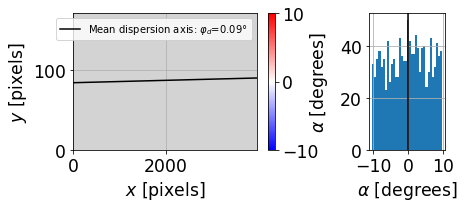

2021-07-07 20:50:00  Image      turn_image           INFO   
	Rotate the image with angle theta=0.09 degree
2021-07-07 20:50:00  Image      turn_image           INFO   
	Rotate the image with angle theta=0.09 degree
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


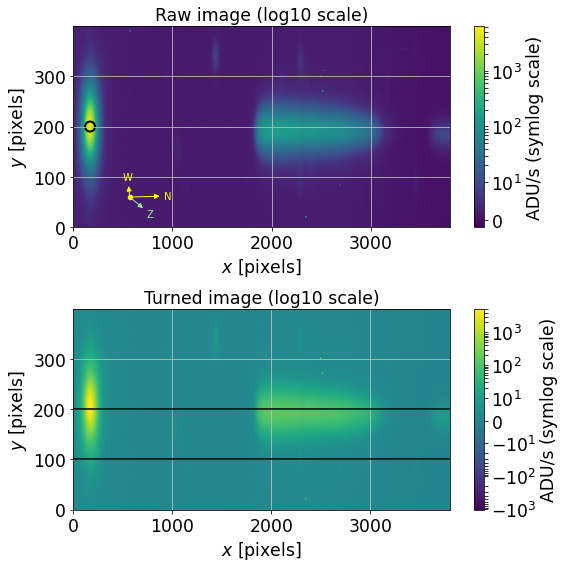

2021-07-07 20:50:11  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-07-07 20:50:11  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-07-07 20:50:11  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
          c0_0              c1_0               c0_1       
    ---------------- ------------------ ------------------
    870.003360014319 2.4424805814485313 0.6699128908605596
2021-07-07 20:50:11  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
          c0_0              c1_0               c0_1       
    ---------------- ------------------ ------------------
    870.003360014319 2.4424805814485313 0.6699128908605596
2021-07-07 20:50:11  spectractor.fit.fitter grad

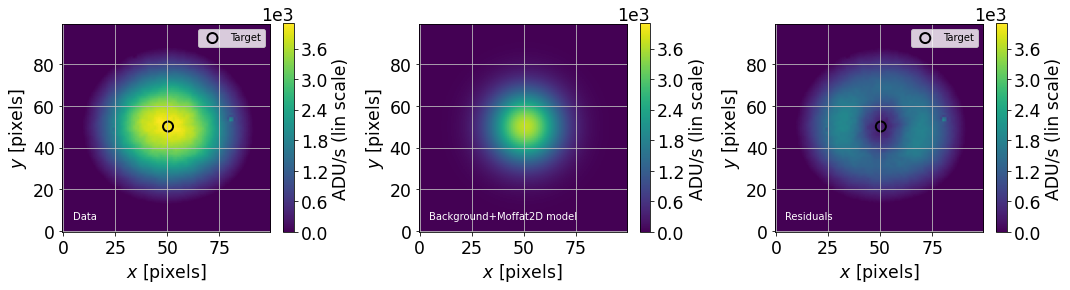

2021-07-07 20:50:12  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=0.0002.
2021-07-07 20:50:12  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the relative change of cost is below ftol=0.0002.


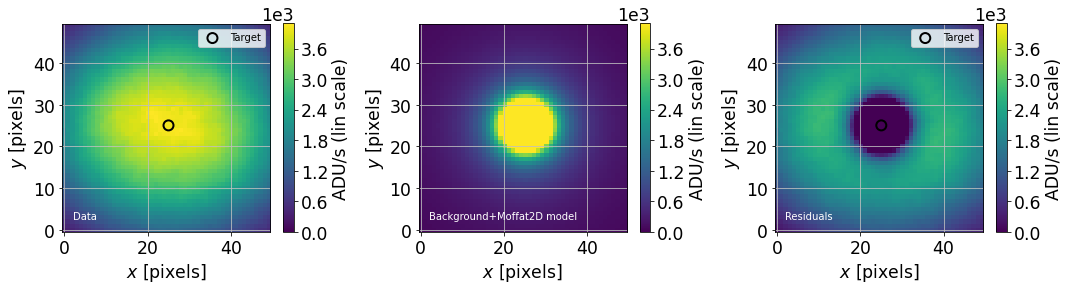

2021-07-07 20:50:13  Image      find_target          INFO   
	X,Y target position in pixels: 272.037,2298.065
2021-07-07 20:50:13  Image      find_target          INFO   
	X,Y target position in pixels: 272.037,2298.065
2021-07-07 20:50:13  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-07-07 20:50:13  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-07-07 20:50:13  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=565.0000000000005 and parameters.LAMBDA_MAX=1089.8000000001198.
2021-07-07 20:50:13  TelescopeTransmission reset_lambda_range   INFO   
	With filter RG610, set parameters.LAMBDA_MIN=565.0000000000005 and parameters.LAMBDA_MAX=1089.8000000001198.
2021-07-07 20:50:13  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*40 pixels and background from 140 to 180 pixels
2021-07-07 20:50:13  spectractor.ext

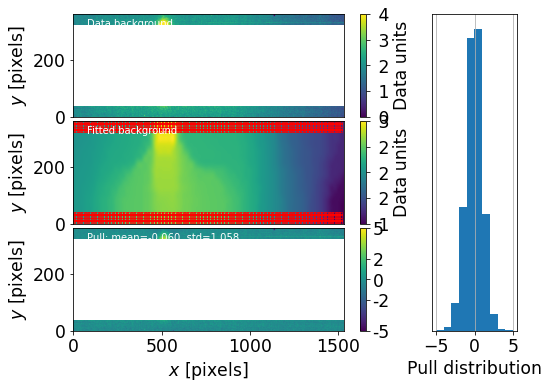

2021-07-07 20:50:16  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
2021-07-07 20:50:16  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
2021-07-07 20:50:35  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table:
lambdas  Dx  Dy ...        gamma               alpha            saturation   
------- --- --- ... ------------------- ------------------- -----------------
    0.0 0.0 0.0 ...   2.217924946376308                 1.1            8500.0
    0.0 0.0 0.0 ...  1.9174614790433864  1.0319761646376706 8500.000000000002
    0.0 0.0 0.0 ...   1.680016840926897  0.9716500831281316            8500.0
    0.0 0.0 0.0 ...  1.5033044422673014  0.9187786685076114            8500.0
    0.0 0.0 0.0 ...  1.3850376933050605  0.8731188338123378            8500.0
    0.0 0.0 0.0 ...  1.3229300042806351  0.8344274920785394            8500.0
    0.0 0.0 0.0 ...   1.

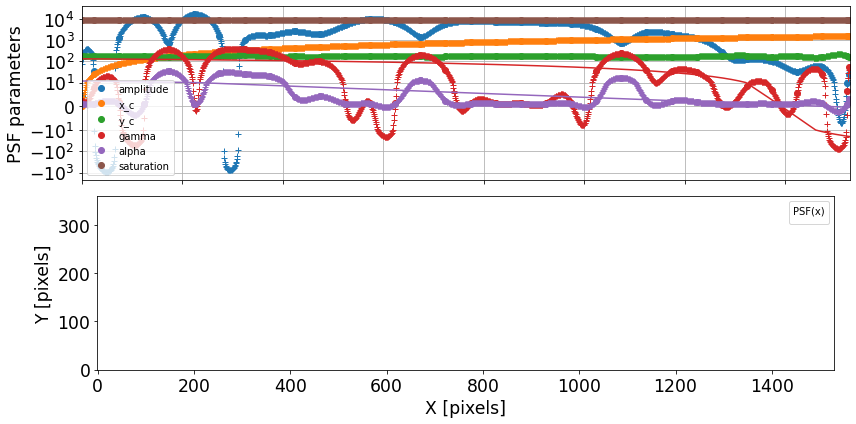

2021-07-07 20:50:37  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start ChromaticPSF polynomial fit with mode=1D and amplitude_priors_method=noprior...
2021-07-07 20:50:39  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=3.7549e+07 initial chisq_red=306.97
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [ -0.8030543    1.49615079  -0.76850582  -6.98858355   7.15701466
 -14.38165557  -1.75738708   2.41024741  -2.43751833]
	New parameters: [ -4.81069894  -1.31504899  -4.72466128   5.91939821 -30.34399922
 -10.91438932   0.12194967  -1.23326949  -2.0514353 ]
	Final cost=2.5534e+07 final chisq_red=208.75 computed in 1.83s
2021-07-07 20:50:39  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=3.7549e+07 initial chisq_red=306.97
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [ -0.8030543    1.49615079  -0.76850582  -6.98858355   7.15701466
 -14.38165557  -1.75738708 

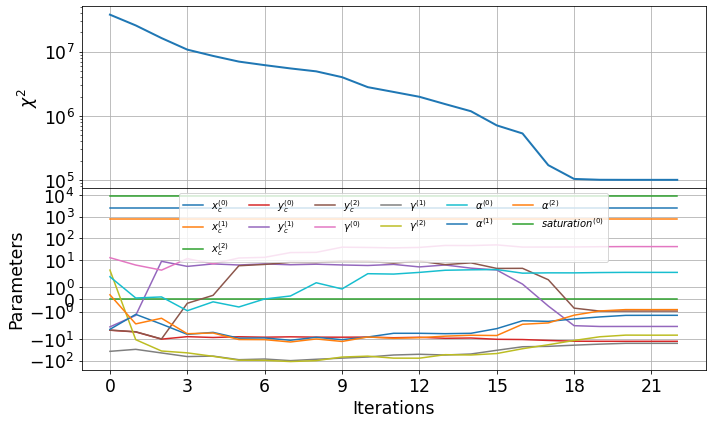

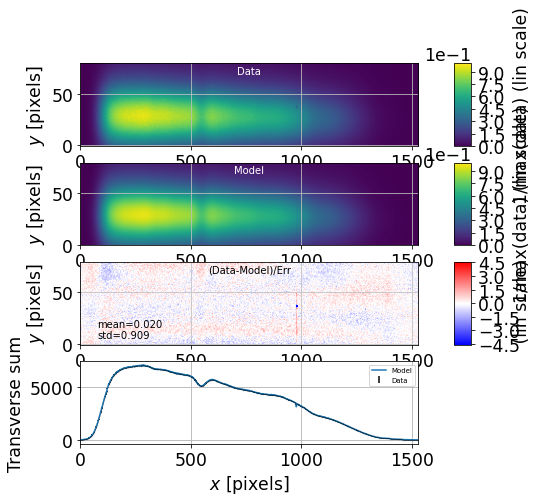

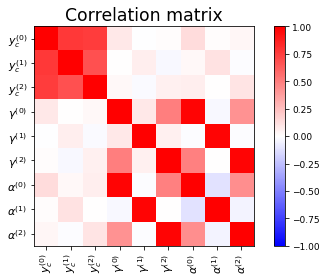

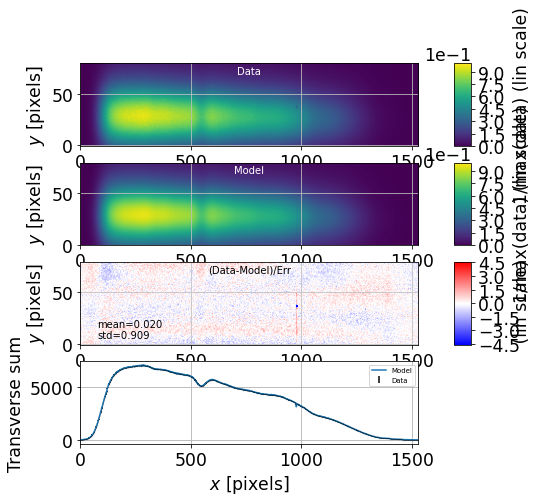

2021-07-07 20:51:18  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
    amplitude       x_c   ...          Dy         Dy_disp_axis
------------------ ------ ... ------------------- ------------
16.596083468780627    0.0 ...  -11.21998433852113          0.0
18.857328136005325    1.0 ... -11.219745046060922          0.0
 18.18897892144727    2.0 ... -11.219510683513391          0.0
22.338000525708974    3.0 ... -11.219281250878538          0.0
 19.41110773922602    4.0 ... -11.219056748156362          0.0
  25.0167050632658    5.0 ... -11.218837175346863          0.0
22.303918028677014    6.0 ... -11.218622532450041          0.0
26.689831638842872    7.0 ... -11.218412819465897          0.0
 23.63826936423658    8.0 ... -11.218208036394458          0.0
25.345349335460433    9.0 ... -11.218008183235668          0.0
               ...    ... ...                 ...          ...
7.5166517331114315 1518.0 ...  -16.53305463119898  

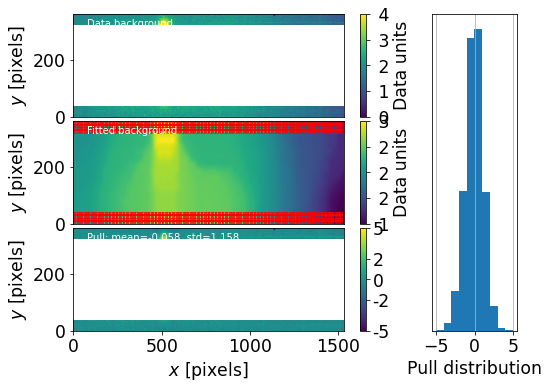

2021-07-07 20:51:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.215 ADU/s, RMS=0.544 ADU/s.
2021-07-07 20:51:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.215 ADU/s, RMS=0.544 ADU/s.
2021-07-07 20:51:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1878:3407,2114:2477] (size (1529, 363))
	New target position in spectrogram frame: [-1608.4630698120336, 178.46644960584808]
2021-07-07 20:51:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1878:3407,2114:2477] (size (1529, 363))
	New target position in spectrogram frame: [-1608.4630698120336, 178.46644960584808]


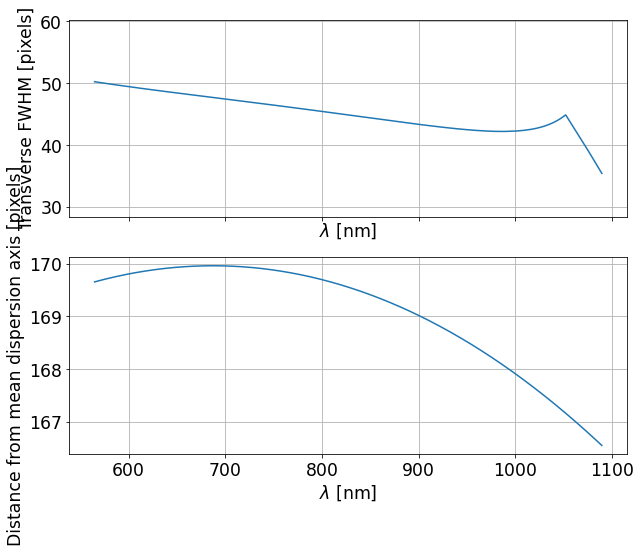

/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


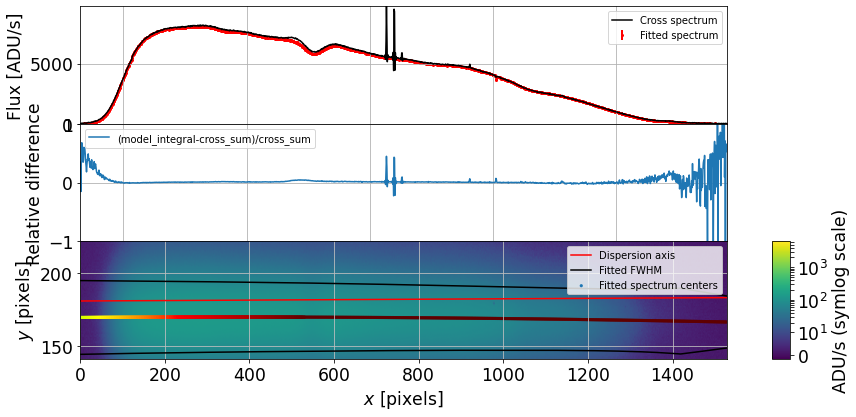

2021-07-07 20:51:23  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...
2021-07-07 20:51:23  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


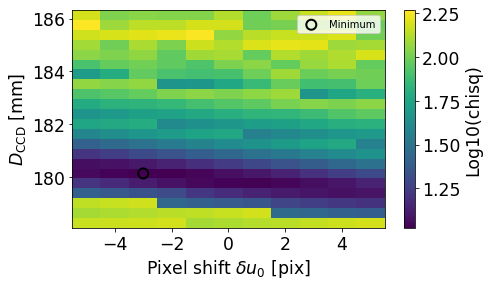

2021-07-07 20:51:43  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -2.000pix
	D = 180.041 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.6 sigma shift)
2021-07-07 20:51:43  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -2.000pix
	D = 180.041 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.6 sigma shift)
2021-07-07 20:51:43  astropy    _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-07-07 20:51:43  astropy    _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-07-07 20:51:43  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000105_spectrum.fits
2021-07-07 20:51:43  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_reprocess/Cor_holo4_003_RG610_HD120144_20210706_000105_spectrum.fits
2021-07-07 20:51:44  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_repro

   Line   Tabulated  Detected   Shift   ...   Chisq    Eqwidth_mod Eqwidth_data
              nm        nm        nm    ...  reduced        nm          nm     
--------- --------- --------- --------- ... ---------- ----------- ------------
$H\alpha$     656.3 651.24207 -5.057939 ...  3.2638485   0.7308559    3.5832155
 $O_2(B)$   687.472 690.79126  3.319266 ...  3.2638485  0.11872391  0.029019924
              760.3  761.0511 0.7511085 ...  3.2638485   1.6174718    1.9688778
    $O_2$     763.1 768.60645 5.5064206 ...  3.2638485  0.43776125    1.9599445
 $O_2(Z)$   822.696  824.8003 2.1043022 ... 0.88405436   0.1668592   -0.7417467
  $H_2 O$     935.0  940.3329 5.3328896 ...   4.453803    3.087938    4.0754156


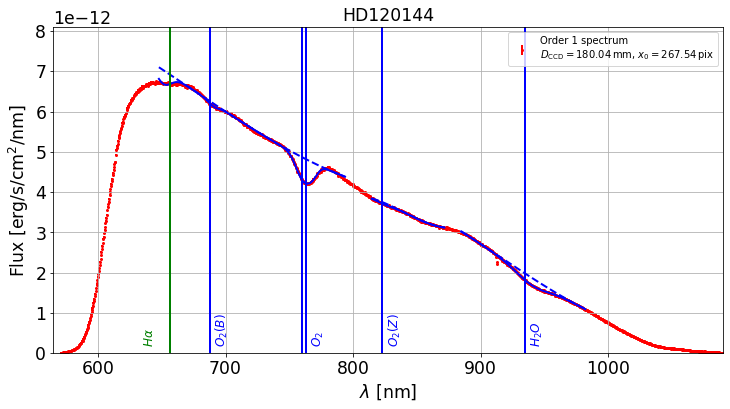

In [464]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)